# Notes on Chapter 7 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from scipy import stats
from sklearn.datasets import load_iris, make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

Estimate of the accuracy of an ensemble with 1000 independent models each with 51% accuracy on a two-class classification problem:

In [2]:
n = 1000
p = 0.51
1 - stats.binom.cdf(int(n/2),n,p)

0.7260985557304961

This is slightly lower than the 75% quoted by the author - I'm not sure if this is a rounding issue, an error in his calculation, or in mine.

Example using the VotingClassifier:

In [3]:
# moons dataset
X,y = make_moons(n_samples=4000, noise=0.3, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=42)

base_models = [
    ('lr', LogisticRegression(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42, max_depth=8)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', SVC(random_state=42)),
]

ensemble_models = [
    ('vc', VotingClassifier(estimators=base_models, voting='hard'))
]

all_models = base_models + ensemble_models

for name,m in all_models:
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    print(f"{m.__class__.__name__}: {accuracy_score(y_test, y_pred) : .03f}")


LogisticRegression:  0.855
DecisionTreeClassifier:  0.888
RandomForestClassifier:  0.898
SVC:  0.907
VotingClassifier:  0.903


Hmm - in this example the voting classifier does not do better than the best models. It's not clear if this is due to having a slightly different dataset and set of models than the author or due to sampling error, although either cautions against assuming that this type of ensemble model will generically increase accuracy.

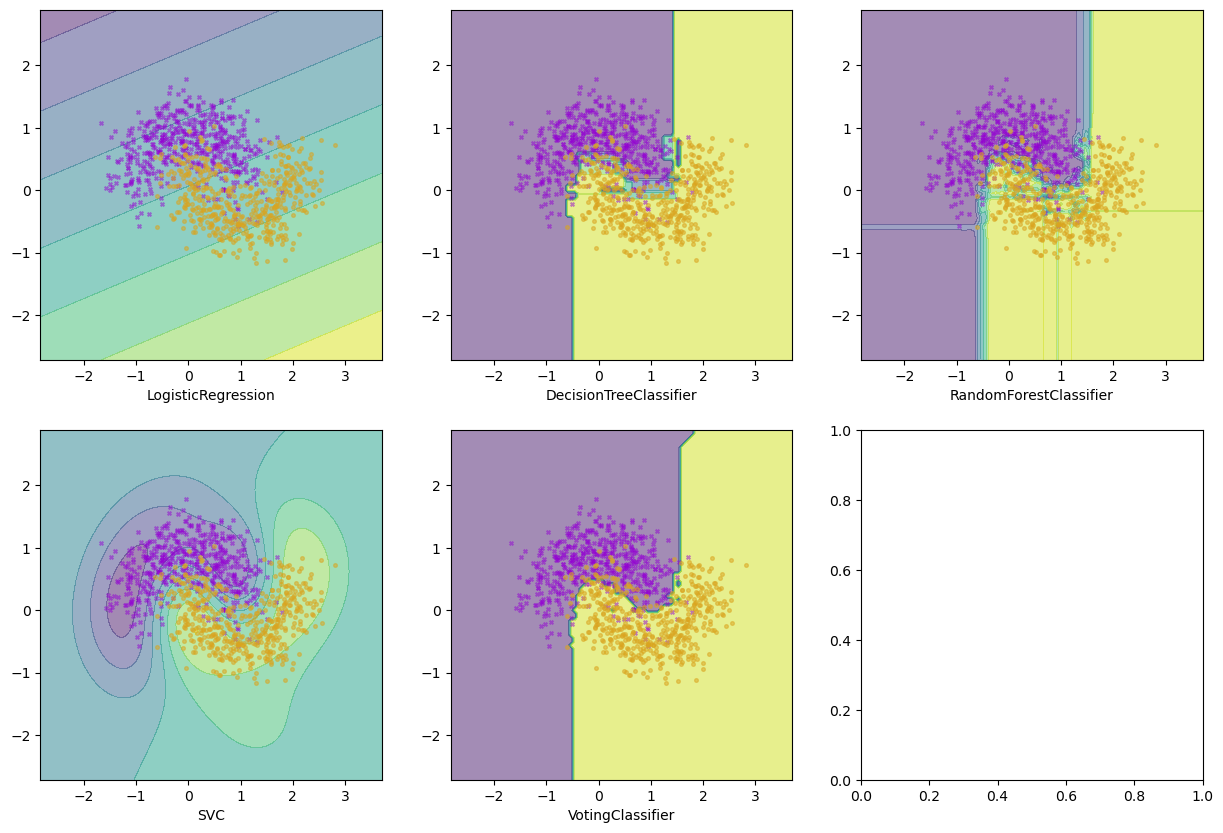

In [4]:
fig,axs = plt.subplots(int((len(all_models) - 1)/3 + 1), 3, figsize=(15,10))
for i,(name,m) in enumerate(all_models):
    disp = DecisionBoundaryDisplay.from_estimator(m, X_train, alpha=0.5, ax=axs.flatten()[i])
    disp.ax_.scatter(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], marker='x', c='darkviolet', s=7, alpha=0.5)
    disp.ax_.scatter(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], marker='o', c='goldenrod', s=7, alpha=0.5)
    disp.ax_.set_xlabel(m.__class__.__name__)

Looking at the decision boundaries, the issue might be that three of the four base classifiers are able to capture almost all of the determinisstic features of the data, so there's not much remaining model specification error for the ensemble model to help with in this problem.

Example of a random forest using sklearn's bagging classifier:

In [5]:
m = BaggingClassifier(DecisionTreeClassifier(max_depth=5),  n_estimators=500, max_samples=100, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
print(f"out of bag score: {m.oob_score_:.03f}, accuracy on test data: {accuracy_score(y_pred, y_test):.03f}")

out of bag score: 0.908, accuracy on test data: 0.911


Here's the same example with pasting:

In [6]:
m = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=500, max_samples=100, bootstrap=False, n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
accuracy_score(y_pred, y_test)

0.914

Example of random patches method (obviously the two moons data is not the best dataset for this technique):

In [7]:
m = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=500, max_samples=100, bootstrap=False, bootstrap_features=True, n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
accuracy_score(y_pred, y_test)

0.907

Example of a random forest using sklearn's RandomForestClassifier:

In [8]:
m = RandomForestClassifier(max_depth=5, n_estimators=500, n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
accuracy_score(y_pred, y_test)

0.903

Example of extremely randomized trees:

In [9]:
m = ExtraTreesClassifier(max_depth=5, n_estimators=500, n_jobs=-1, random_state=42)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
accuracy_score(y_pred, y_test)

0.878

Example of using feature_importances_ to try to understand a random forest:

In [10]:
iris = load_iris()
m = RandomForestClassifier(max_depth=5, n_estimators=500, n_jobs=-1, random_state=42)
m.fit(iris["data"], iris["target"])
order = np.flip(np.argsort(m.feature_importances_))
for name,importance in zip(np.array(iris["feature_names"])[order], m.feature_importances_[order]):
    print(f"{name:24s} {importance:.03f}")

petal length (cm)        0.443
petal width (cm)         0.425
sepal length (cm)        0.112
sepal width (cm)         0.021


Example of using AdaBoost with decision stumps:

In [11]:
m = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)
accuracy_score(y_pred, y_test)

0.905

Simple manual gradient boosting example:

In [12]:
n_estimators = 50
learning_rate = 0.5
base_models = [DecisionTreeRegressor(max_depth=3, random_state=(i+1)*42) for i in range(n_estimators)]
y_train_residual = y_train

for i in range(n_estimators):
    base_models[i].fit(X_train, y_train_residual)
    y_train_residual = y_train_residual - learning_rate*base_models[i].predict(X_train)

y_pred = 0.5 < sum(base_models[i].predict(X_test) for i in range(n_estimators))
accuracy_score(y_pred, y_test)

0.89